In [190]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

In [191]:
test=pd.read_csv('test_dataset.csv')
train=pd.read_csv('train_dataset.csv')

In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5550 entries, 0 to 5549
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tconst              5550 non-null   object 
 1   primaryTitle        5550 non-null   object 
 2   originalTitle       5550 non-null   object 
 3   startYear           5550 non-null   int64  
 4   runtimeMinutes      5550 non-null   int64  
 5   Animation           5550 non-null   int64  
 6   Fantasy             5550 non-null   int64  
 7   GameShow            5550 non-null   int64  
 8   History             5550 non-null   int64  
 9   Music               5550 non-null   int64  
 10  Musical             5550 non-null   int64  
 11  News                5550 non-null   int64  
 12  SciFi               5550 non-null   int64  
 13  Sport               5550 non-null   int64  
 14  War                 5550 non-null   int64  
 15  Western             5550 non-null   int64  
 16  averag

In [193]:
baelineModel = train['revenue'].mean(axis=0)
SST = sum((train['revenue']- baelineModel)**2)
SST

2.5372449530248577e+20

In [194]:
linreg = smf.ols(formula = 'revenue ~ startYear + runtimeMinutes + Animation + Fantasy + GameShow + History+Music + Musical + News + SciFi + Sport + War +Western + averageRating + numVotes + budget + isTopActor + isTopDirector + yearsSinceProduced',
                   data = train).fit()

print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     495.1
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:39:57   Log-Likelihood:            -1.1176e+05
No. Observations:                5550   AIC:                         2.236e+05
Df Residuals:                    5532   BIC:                         2.237e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -671.5343    202

In [195]:
# removing Music Fantasy News HistoryAnimation Gameshow Musical War +Western + averageRating+ Sport+ runtimeMinutes+startYear
linreg = smf.ols(formula = 'revenue ~ SciFi  + numVotes + budget + isTopActor + isTopDirector + yearsSinceProduced',
                   data = train).fit()

print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     1401.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:40:01   Log-Likelihood:            -1.1177e+05
No. Observations:                5550   AIC:                         2.235e+05
Df Residuals:                    5543   BIC:                         2.236e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.269e+07   5.75

In [197]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)

VIF(train, ['SciFi', 'numVotes','budget', 'isTopActor','isTopDirector', 'yearsSinceProduced'])


SciFi                 1.052746
numVotes              1.423608
budget                1.123771
isTopActor            1.399782
isTopDirector         1.462944
yearsSinceProduced    1.026661
dtype: float64

In [198]:
linreg.predict(test)

0       1.294560e+08
1       1.212517e+07
2       5.505249e+07
3       5.279516e+08
4       6.187867e+07
            ...     
2348    2.357342e+08
2349    9.129106e+07
2350    4.853948e+07
2351    5.891340e+08
2352    1.101547e+08
Length: 2353, dtype: float64

In [201]:
df_test = test[['revenue','SciFi', 'numVotes','budget', 'isTopActor','isTopDirector', 'yearsSinceProduced']]
df_train = train[['revenue','SciFi', 'numVotes','budget', 'isTopActor','isTopDirector', 'yearsSinceProduced']]


def OSR2(model, df_train, df_test, dependent_var):   
    
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    
    return 1 - SSE/SST

In [202]:
print('The OSR2 for the Linear Regression model is: ',OSR2(linreg, df_train, df_test, dependent_var='revenue'))

The OSR2 for the Linear Regression model is:  0.5623209277886974


# CART MODEL 

In [203]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV


In [205]:
# We use here cross validation to select the best ccp_alpha for our model
#X_train = train.drop(['revenue','tconst','primaryTitle','originalTitle'], axis = 1)
X_train = train[['SciFi', 'numVotes','budget', 'isTopActor','isTopDirector', 'yearsSinceProduced']]
y_train = train['revenue']
X_test = test[['SciFi', 'numVotes','budget', 'isTopActor','isTopDirector', 'yearsSinceProduced']]
y_test = test['revenue']

grid_values = {'ccp_alpha': np.linspace(0.0, 0.1, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 
            
dtr = DecisionTreeRegressor()
dtr_cv_custom = GridSearchCV(dtr, param_grid = grid_values, scoring = 'r2', cv=10, verbose = 1) 
# we use here the R2 score as optimization variable since we are dealing with a regression model
dtr_cv_custom.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.020...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
            

In [206]:
dtr_cv_custom.best_params_['ccp_alpha']

0.0

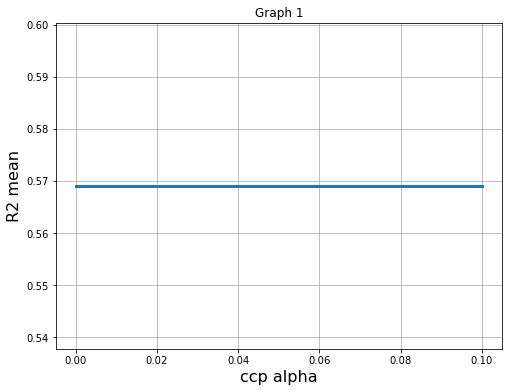

Grid best parameter ccp_alpha :  0.0
Grid best score (R2):  0.5690796796361659


In [207]:
acc = dtr_cv_custom.cv_results_['mean_test_score'] 
ccp = dtr_cv_custom.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.title('Graph 1')
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('R2 mean', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()
print('Grid best parameter ccp_alpha : ', dtr_cv_custom.best_params_['ccp_alpha'])
print('Grid best score (R2): ', dtr_cv_custom.best_score_)

In [208]:
#Now that we have our best hyper parameter alpha, let's put it in our regression Tree.
dtrOptimal = DecisionTreeRegressor(min_samples_leaf=5, 
                             ccp_alpha= 0.0,
                             random_state = 88)
dtrOptimal = dtrOptimal.fit(X_train, y_train)

In [209]:
dtrOptimal.predict(X_test)

array([1.35459733e+08, 4.49649474e+07, 3.85395752e+07, ...,
       7.37024568e+07, 2.86408790e+08, 9.00524841e+07])

In [210]:
def OSR22(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    
    return (1 - SSE/SST)

print('The OSR2 : ',OSR22(dtrOptimal,X_test, y_test, y_train))

The OSR2 :  0.5310423468981504


# Random Forest Regressor

In [211]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=6, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=6, min_samples_leaf=5, n_estimators=500,
                      random_state=88)

In [212]:
print('OSR2:', round(OSR22(rf, X_test, y_test, y_train), 5))

OSR2: 0.62216


# Gradient Boosting Regressor

In [213]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_features=6, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=1)
gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1 40371881474463888.0000            2.56s
         2 35943055650075904.0000            2.26s
         3 32364060419678524.0000            2.08s
         4 29409352491484528.0000            2.08s
         5 26996997571361684.0000            2.04s
         6 24976066519249680.0000            2.00s
         7 23325604360041788.0000            1.98s
         8 21952152553123056.0000            1.99s
         9 20758044947655028.0000            1.97s
        10 19783681691988656.0000            1.96s
        20 15472454742587102.0000            1.90s
        30 14117980876718160.0000            1.75s
        40 13427318796529306.0000            1.62s
        50 12875609421938022.0000            1.52s
        60 12442471829092384.0000            1.47s
        70 12127282711143840.0000            1.43s
        80 11877609723729976.0000            1.38s
        90 11653127013003130.0000            1.33s
       100 11436851831857606.0000   

GradientBoostingRegressor(max_features=6, min_samples_leaf=5, n_estimators=500,
                          random_state=88, verbose=1)

In [214]:
print('OSR2:', round(OSR22(gbr, X_test, y_test, y_train), 5))

OSR2: 0.56419


# Boostrap

In [215]:
def OS_R_squared(predictions, y_test,y_train):
    SSE = np.sum((y_test-predictions)**2)
    SST = np.sum((y_test-np.mean(y_train))**2)
    r2 = 1-SSE/SST
    return r2

def mean_squared_error(predictions, y_test,y_train):
    MSE = np.mean((y_test-predictions)**2)
    return MSE

def mean_absolute_error(predictions, y_test,y_train):
    MAE = np.mean(np.abs(y_test-predictions))
    return MAE

In [216]:
import time
from sklearn.metrics import accuracy_score 

def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    tic = time.time()
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df
def accuracy(predictions, y_test,y_train): 
    return accuracy_score(y_test, predictions)

In [217]:
bs_output_CART = bootstrap_validation(X_test,y_test,y_train,dtrOptimal,
                                 metrics_list=[OS_R_squared],
                                 sample = 5000)
bs_output_LinearRegression = bootstrap_validation(X_test,y_test,y_train,linreg,
                                 metrics_list=[OS_R_squared],
                                 sample = 5000)
bs_output_GradientBoosting = bootstrap_validation(X_test,y_test,y_train,gbr,
                                 metrics_list=[OS_R_squared],
                                 sample = 5000)
bs_output_RF = bootstrap_validation(X_test,y_test,y_train,rf,
                                 metrics_list=[OS_R_squared],
                                 sample = 5000)

(5000, 1)
(5000, 1)
(5000, 1)
(5000, 1)


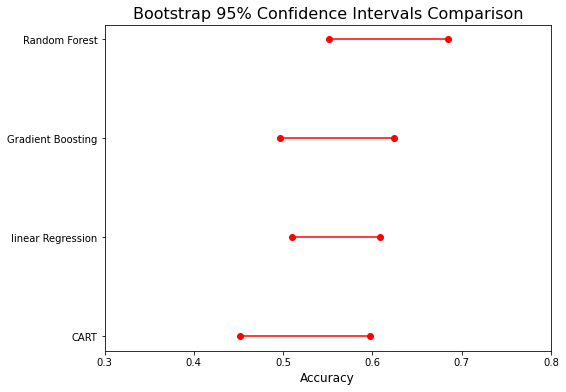

In [228]:
CI_CART = np.quantile(bs_output_CART.iloc[:,0],np.array([0.025,0.975]))
CI_LR = np.quantile(bs_output_LinearRegression.iloc[:,0],np.array([0.025,0.975]))
CI_GBR = np.quantile(bs_output_GradientBoosting.iloc[:,0],np.array([0.025,0.975]))
CI_RF = np.quantile(bs_output_RF.iloc[:,0],np.array([0.025,0.975]))



data_dict = {}
data_dict['Model'] = ['CART','linear Regression','Gradient Boosting','Random Forest']
data_dict['Lower'] = [CI_CART[0],CI_LR[0],CI_GBR[0],CI_RF[0]]
data_dict['Upper'] = [CI_CART[1],CI_LR[1],CI_GBR[1],CI_RF[1]]
dataset = pd.DataFrame(data_dict)
plt.figure(figsize=(8,6))
for lower,upper,y in zip(dataset['Lower'],dataset['Upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='red')
plt.yticks(range(len(dataset)),list(dataset['Model']))
plt.title('Bootstrap 95% Confidence Intervals Comparison', fontsize = 16)
plt.xlabel('Accuracy', fontsize=12)
plt.xlim([0.3,0.8])
plt.show()

In [227]:
dataset.style.hide_index()

Model,Lower,Upper
CART,0.452048,0.597261
linear Regression,0.509767,0.608667
Gradient Boosting,0.496204,0.624146
Random Forest,0.551222,0.684663
